In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path
import imageio
import re
from IPython import display

SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 64
Z_DIM = 256
BZ = (BATCH_SIZE, Z_DIM)
BUF = 20000

DC_LR = 2.5e-04
DC_EPOCH = 256

W_LR = 2.0e-04
W_EPOCH = 1000
WClipLo = -0.01
WClipHi = 0.01

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [4]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


In [5]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [6]:
df['true_label'] = True

In [7]:
test = df.loc[6734, 'Captions'][0]

In [8]:
import tensorflow_addons as tfa

# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption, caption_mismatch, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])

    return tf.cast(caption, tf.int32), tf.cast(caption_mismatch, tf.int32), img

def training_data_generator_flip(caption, caption_mismatch, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    
    img = tf.image.flip_left_right(img)
    caption = tf.cast(caption, tf.int32)

    return tf.cast(caption, tf.int32), tf.cast(caption_mismatch, tf.int32), img

def dataset_generator(df, batch_size, data_generator):
    # load the training data into two NumPy arrays
    captions = df['Captions'].values
    caption = []
    caption_mismatch = []
    image_path = df['ImagePath'].values
    
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    for i in range(len(captions)):
        caption.append(random.choice(captions[i]))
        
        # Assert that all image in filenames are quiet different
        # we add a negative sample to make our GAN learn better
        random_mismatch = random.randrange(len(captions)-1)
        if random_mismatch == i:
            random_mismatch += 1
        
        caption_mismatch.append(random.choice(captions[random_mismatch]))
        
        
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    
    caption_mismatch = np.asarray(caption_mismatch)
    caption_mismatch = caption_mismatch.astype(np.int)
 
    
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == len(image_path)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, caption_mismatch, image_path))
    
#     dataset1 = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset2 = dataset.map(training_data_generator_flip, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#     dataset = dataset1.concatenate(dataset2)
    dataset = dataset2
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=50)

    return dataset

In [9]:
BATCH_SIZE = 64
dataset = dataset_generator(df, BATCH_SIZE, training_data_generator)

len(dataset)*BATCH_SIZE

7360

In [10]:
sample_caption, sample_caption_mismatch, sample_image = next(iter(dataset))

In [11]:
sample_caption[0]

<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([   4,    1,    5,   37,   44,  294,    2,    3,    8,   77,   44,
         31, 5427, 5427, 5427, 5427, 5427, 5427, 5427, 5427], dtype=int32)>

In [12]:
sample_caption_mismatch[0]

<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([   4,    1,    5,    2,   10,    6,   12,    7,   20,   88, 5427,
       5427, 5427, 5427, 5427, 5427, 5427, 5427, 5427, 5427], dtype=int32)>

In [1]:
import gensim.downloader
# load the whole embedding into memory
w2v_model = gensim.downloader.load('word2vec-google-news-300')

[--------------------------------------------------] 1.7% 27.5/1662.8MB downloaded

KeyboardInterrupt: 

In [54]:
class TextEncoder(tf.keras.Model):
    """
    Encode text (a caption) into hidden representation
    input: text, which is a list of ids
    output: embedding, or hidden representation of input text in dimension of RNN_HIDDEN_SIZE
    """
    def __init__(self, hparas):
        super(TextEncoder, self).__init__()
        self.hparas = hparas
        self.batch_size = self.hparas['BATCH_SIZE']
        
        self.inputs = tf.keras.layers.InputLayer((hparas['MAX_SEQ_LENGTH'],))
        
        # embedding with tensorflow API
        self.embedding = tf.keras.layers.Embedding(input_dim=hparas['VOCAB_SIZE'],
                            output_dim=self.hparas['EMBED_DIM'])
        # RNN, here we use GRU cell, another common RNN cell similar to LSTM
        self.gru = layers.GRU(self.hparas['RNN_HIDDEN_SIZE'],
                              return_sequences=True,
                              return_state=True,
                              recurrent_initializer='glorot_uniform')
    
    def call(self, text, hidden):
        text = self.inputs(text)
        text = self.embedding(text)
        output, state = self.gru(text, initial_state = hidden)
        return output[:, -1, :], state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.hparas['BATCH_SIZE'], self.hparas['RNN_HIDDEN_SIZE']))

In [14]:
EPOCHS = 40
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'VOCAB_SIZE': 5428,          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 128,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    # 'N_EPOCH': 20,
    'N_SAMPLE': num_training_sample,          # size of training data
    'CHECKPOINTS_DIR': './checkpoints/demo',  # checkpoint path
    "text_ckpt_DIR": './checkpoints/text',    # text checkpoint path
    'PRINT_FREQ': 1                           # printing frequency of loss
}

In [15]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

# text autoencoder

In [92]:
class Text_autoencoder(tf.keras.Model):
    def __init__(self, hparas):
        super(Text_autoencoder, self).__init__()
        self.hparas = hparas
        
        self.embedding = layers.Embedding(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM'])
        self.gru = layers.GRU(self.hparas['RNN_HIDDEN_SIZE'],
                              return_sequences=True,
                              return_state=True,
                              recurrent_activation='sigmoid',
                              recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(1)
        self.d2 = tf.keras.layers.Dense(10)
    
    def call(self, text, hidden):
        text = self.embedding(text)
        output, state = self.gru(text)
        return output[:,-1,:], state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.hparas['BATCH_SIZE'], self.hparas['RNN_HIDDEN_SIZE']))

In [93]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(1024)
        self.W2 = tf.keras.layers.Dense(1024)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape == (batch_size, max_length, hidden_size)
        context_vector = attention_weights * values
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [94]:
class Text_autodecoder(tf.keras.Model):
    def __init__(self, hparas):
        super(Text_autodecoder, self).__init__()
        self.hparas = hparas
        
        self.embedding = layers.Embedding(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM'])
        self.gru = layers.GRU(self.hparas['RNN_HIDDEN_SIZE'],
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = layers.Dense(self.hparas['VOCAB_SIZE'])
        
        self.attention = BahdanauAttention(self.hparas['RNN_HIDDEN_SIZE'])
        
    def call(self, dec_input, dec_hidden, enc_output):
        context_vector, attention_weights = self.attention(dec_hidden, enc_output)
        
        dec_input = self.embedding(dec_input)
        
        dec_input = tf.concat([tf.expand_dims(context_vector, 1), dec_input], axis=-1)
        
        output, state = self.gru(dec_input)
        
        output = tf.reshape(output, (-1, output.shape[2]))
        
        output = self.fc(output)
        
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.hparas['BATCH_SIZE'], self.hparas['RNN_HIDDEN_SIZE']))

In [95]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    """Calculate the loss value
    Args:
        real: the true label  shape == (batch_size,) -> (128,)
        pred: the probability of each word from the vocabulary, is the output from the decoder 
                 shape == (batch_size, vocab_size) -> (128, 6082)

    Returns: 
        the average loss of the data in a batch size
    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #print(loss_)
    return tf.reduce_mean(loss_)

optimizer = tf.keras.optimizers.Adam()
encoder = Text_autoencoder(hparas)
decoder = Text_autodecoder(hparas)

text_ckpt = tf.train.Checkpoint(optimizer=optimizer, Encoder=encoder, Decoder=decoder)
text_manager = tf.train.CheckpointManager(text_ckpt, hparas['text_ckpt_DIR'], max_to_keep=3)
#text_ckpt.restore(text_manager.latest_checkpoint)

In [99]:
#@tf.function
def train_step(text, encoder_hidden, decoder_hidden):
    loss = 0
    # shape of text:(64, 20)
    text = tf.cast(text, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        # shape of enc_output:(64, 20, 128)
        enc_output, enc_hidden = encoder(text, encoder_hidden)
        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([1] * BATCH_SIZE, 1)
        for t in range(1, text.shape[1]):
            # shape of predictions:(64, 5428)
            predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)
            
            loss += loss_function(text[:, t], predictions)
            
            dec_input = tf.expand_dims(text[:, t], 1)
    
    batch_loss = (loss / int(text.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [101]:
# set the epochs for training
EPOCHS = 50
steps_per_epoch = int(hparas['N_SAMPLE'] / hparas['BATCH_SIZE'])
encoder_hidden = encoder.initialize_hidden_state()
decoder_hidden = decoder.initialize_hidden_state()

for epoch in range(EPOCHS):
    start = time.time()

    # get the initial hidden state of gru
    total_loss = 0

    for image, caption, caption_mismatch in dataset:
        batch_loss = train_step(caption, encoder_hidden, decoder_hidden)
        total_loss += batch_loss

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        text_manager.save()
        
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Loss 2.3208
Time taken for 1 epoch 20.55367136001587 sec

Epoch 2 Loss 2.1773
Time taken for 1 epoch 20.296351194381714 sec

Epoch 3 Loss 2.0776
Time taken for 1 epoch 20.4238920211792 sec

Epoch 4 Loss 2.0110
Time taken for 1 epoch 20.706032514572144 sec

Epoch 5 Loss 1.9641
Time taken for 1 epoch 20.54761552810669 sec

Epoch 6 Loss 1.9320
Time taken for 1 epoch 20.796941995620728 sec

Epoch 7 Loss 1.9066
Time taken for 1 epoch 20.4653537273407 sec

Epoch 8 Loss 1.8866
Time taken for 1 epoch 20.62321376800537 sec

Epoch 9 Loss 1.8717
Time taken for 1 epoch 20.61115074157715 sec

Epoch 10 Loss 1.8576
Time taken for 1 epoch 20.620462894439697 sec

Epoch 11 Loss 1.8466
Time taken for 1 epoch 20.62728977203369 sec

Epoch 12 Loss 1.8359
Time taken for 1 epoch 20.666796445846558 sec

Epoch 13 Loss 1.8277
Time taken for 1 epoch 20.60951280593872 sec

Epoch 14 Loss 1.8185
Time taken for 1 epoch 20.483885526657104 sec

Epoch 15 Loss 1.8117
Time taken for 1 epoch 20.636958122253418 sec


# GAN

In [102]:
def Generator():
    # x-shape
    xh, xw, xc = IMG_SHAPE
    # z-shape
    zh = xh // 4
    zw = xw // 4
    
    text_input = layers.Input(shape=hparas['RNN_HIDDEN_SIZE']+hparas['Z_DIM'])
    x = keras.layers.Dense(1024)(text_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Dense(units  =  zh * zw << 8)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Reshape(target_shape = (zh, zw, 256))(x)
    x = keras.layers.Conv2DTranspose(filters = 32, kernel_size = 5, 
                                     strides = 2, padding = "SAME")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2DTranspose(filters = xc, kernel_size = 5, 
                                     strides = 2, padding = "SAME", activation = keras.activations.tanh)(x)

    return tf.keras.models.Model([text_input], x, name='generator')


def Discriminator():
    filters = int(hparas['RNN_HIDDEN_SIZE']*2 / (4 * 4))
    
    img_input = layers.Input(shape=IMG_SHAPE)
    x = keras.layers.Conv2D(filters = 32, kernel_size = 5, strides = (2, 2), 
                            padding = "SAME", input_shape = IMG_SHAPE)(img_input)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2D(filters = 64, kernel_size = 5, 
                            strides = (2, 2), padding = "SAME")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2D(filters = 128, kernel_size = 5, 
                            strides = (2, 2), padding = "SAME")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2D(filters = 256, kernel_size = 5, 
                            strides = (2, 2), padding = "SAME")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)

    text_input = layers.Input(shape=hparas['RNN_HIDDEN_SIZE']*2)
    x_text = layers.Reshape((4, 4, filters))(text_input)

    x = layers.concatenate([x, x_text], axis=-1)
    x = layers.Conv2D(filters = 256 + filters, 
                      kernel_size = 1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(filters = 256 + filters, 
                      kernel_size = 4)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(units  =  1)(x)
    x = tf.squeeze(x, [1, 2])

    return tf.keras.models.Model([img_input, text_input], x, name='discriminator')
    
s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [103]:
text_encoder = TextEncoder(hparas)
WG = Generator()
WD = Discriminator()

In [104]:
#TODO
optimizer_g = keras.optimizers.Adam(W_LR, beta_1 = 0, beta_2 = 0.9)
optimizer_d = keras.optimizers.Adam(W_LR, beta_1 = 0, beta_2 = 0.9)
alpha = 0

@tf.function
def WGTrain(caption, caption_mismatch, c1, hidden):
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    
    with tf.GradientTape() as tpg:
        text_embed, hidden = encoder(caption, hidden)
        match_z = tf.concat([noise, text_embed], axis=-1)
        
        c0 = WG(match_z, training = True)
        
        z1 = WD([c1, match_z], training = True)
        z0 = WD([c0, match_z], training = True)

        ld = tf.reduce_mean(z0) - tf.reduce_mean(z1)
        lg = - tf.reduce_mean(z0)
    
    trainable_variables = WG.trainable_variables 
    gradient_g = tpg.gradient(lg, trainable_variables)
    optimizer_g.apply_gradients(zip(gradient_g, trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(caption, caption_mismatch, c1, hidden):
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    epsilon = tf.keras.backend.epsilon()
    
    with tf.GradientTape() as tpd:
        epsilon = tf.random.uniform(shape=[BATCH_SIZE, 1, 1, 1], minval=0., maxval=1.)
        
        text_embed, hidden = encoder(caption, hidden)
        match_z = tf.concat([noise, text_embed], axis=-1)
        
        text_mismatch_embed, hidden = encoder(caption_mismatch, hidden)
        mismatch_z = tf.concat([noise, text_mismatch_embed], axis=-1)
        
        c0 = WG(match_z, training = True)
        c2 = epsilon*c1 + (1-epsilon)*c0
        
        z0 = WD([c0, match_z], training = True)
        z1 = WD([c1, match_z], training = True)
        z2 = WD([c2, match_z], training = True)
        
        p_mismatch = WD([c1, mismatch_z], training = True)
        
        z2_grad = tf.gradients(z2, [c2])[0]
        z2_grad = tf.math.sqrt(tf.reduce_sum(tf.math.square(z2_grad), axis = [1, 2, 3]))
        gradient_penalty = tf.reduce_mean((z2_grad-1)**2)
        
        ld = tf.reduce_mean(z0) - (1 - alpha)*tf.reduce_mean(z1) + 10 * gradient_penalty
        ld = ld + alpha*tf.reduce_mean(p_mismatch)
        
        lg = -tf.reduce_mean(z0)
    
    trainable_variables = WD.trainable_variables + encoder.trainable_variables
    gradient_d = tpd.gradient(ld, trainable_variables)
    optimizer_d.apply_gradients(zip(gradient_d, trainable_variables))

    return lg, ld

In [105]:
'''import shutil

pathTest = r"checkpoints"

try:
    shutil.rmtree(pathTest)
except OSError as e:
    print(e)
else:
    print("The directory is deleted successfully")'''

'import shutil\n\npathTest = r"checkpoints"\n\ntry:\n    shutil.rmtree(pathTest)\nexcept OSError as e:\n    print(e)\nelse:\n    print("The directory is deleted successfully")'

In [106]:
'''# one benefit of tf.train.Checkpoint() API is we can save everything seperately
checkpoint_dir = './checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=optimizer_g,
                                 discriminator_optimizer=optimizer_d,
                                 generator=WG,
                                 discriminator=WD)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
#checkpoint.restore(manager.latest_checkpoint)'''

'# one benefit of tf.train.Checkpoint() API is we can save everything seperately\ncheckpoint_dir = \'./checkpoints/\'\ncheckpoint_prefix = os.path.join(checkpoint_dir, "ckpt")\ncheckpoint = tf.train.Checkpoint(generator_optimizer=optimizer_g,\n                                 discriminator_optimizer=optimizer_d,\n                                 generator=WG,\n                                 discriminator=WD)\nmanager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)\n#checkpoint.restore(manager.latest_checkpoint)'

In [107]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

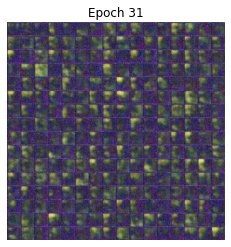

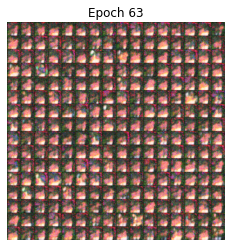

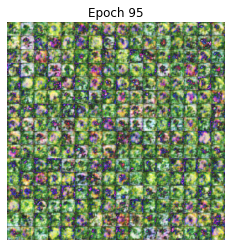

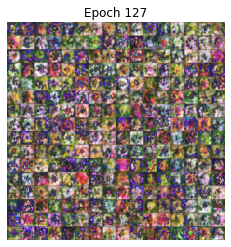

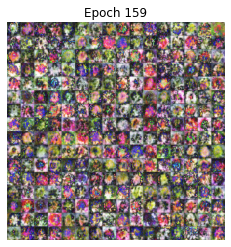

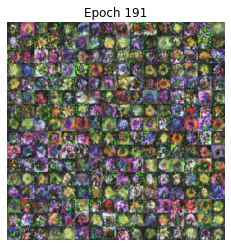

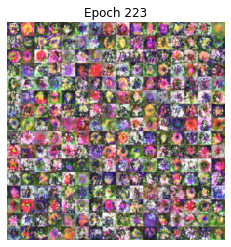

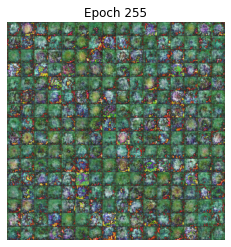

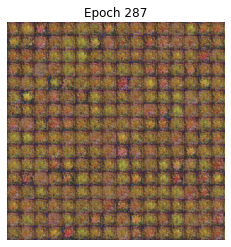

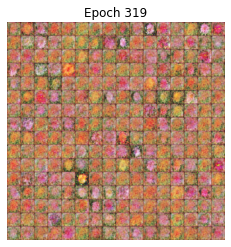

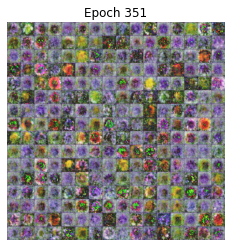

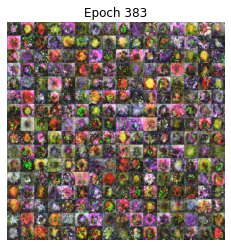

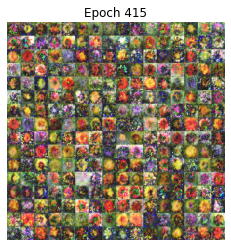

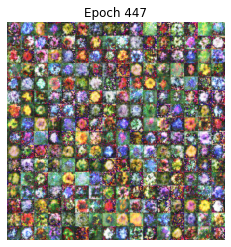

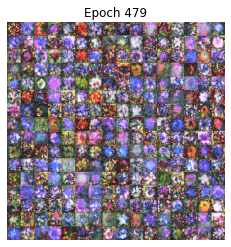

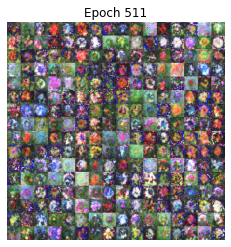

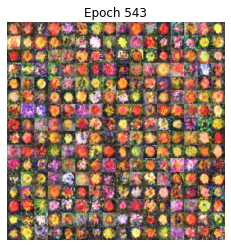

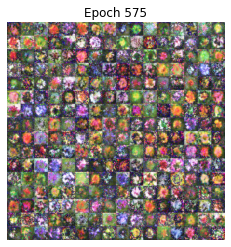

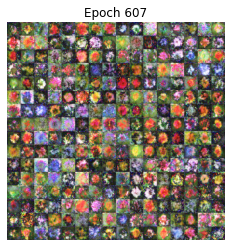

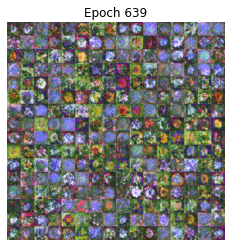

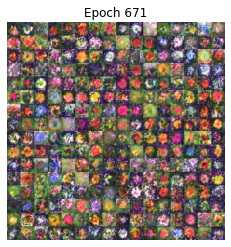

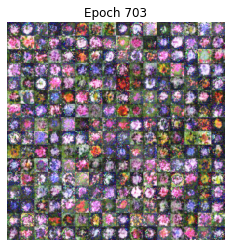

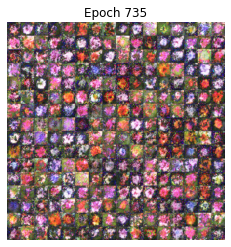

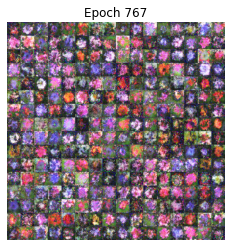

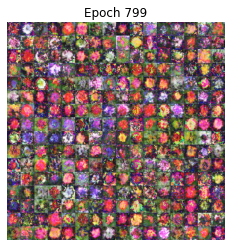

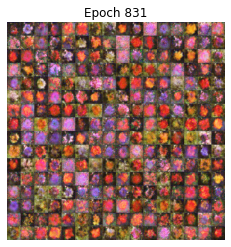

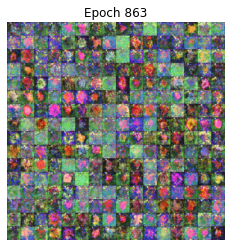

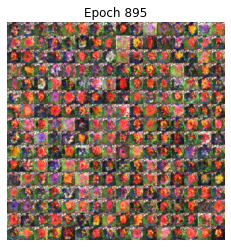

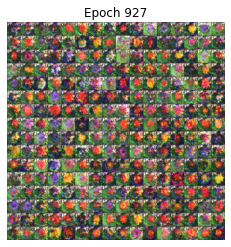

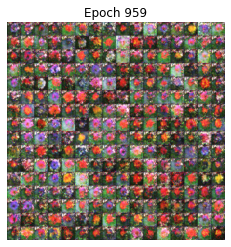

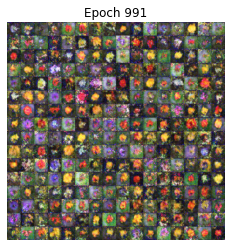

In [108]:
wlg = [None] * W_EPOCH
wld = [None] * W_EPOCH
wsp = [None] * W_EPOCH
rsTrain = float(BATCH_SIZE) / float(len(dataset))
ctr = 0

hidden = text_encoder.initialize_hidden_state()

for ep in range(W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    for caption, caption_mismatch, c1 in dataset:
        lg, ld = WTrain[ctr](caption, caption_mismatch, c1, hidden)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/w_%04d.png" % ep
    )
    wsp[ep] = img
    
    #checkpoint.save(file_prefix = checkpoint_prefix)
    if (ep+1) % 32 == 0:     
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

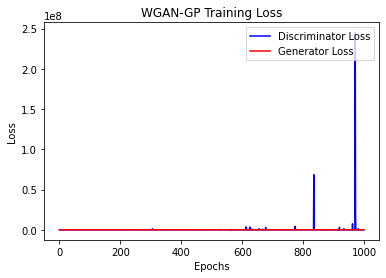

In [109]:
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN-GP Training Loss")
plt.show()

# test

In [110]:
@tf.function
def test_step(caption, noise, hidden):
    text_embed, hidden = text_encoder(caption, hidden)
    fake_image = WG(tf.concat([text_embed, noise], axis=-1))
    return fake_image

In [111]:
def testing_data_generator(caption, index):
    caption = tf.cast(caption, tf.float32)
    return caption, index

def testing_dataset_generator(batch_size, data_generator):
    data = pd.read_pickle('./dataset/testData.pkl')
    captions = data['Captions'].values
    caption = []
    for i in range(len(captions)):
        caption.append(captions[i])
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    index = data['ID'].values
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [112]:
testing_dataset = testing_dataset_generator(hparas['BATCH_SIZE'], testing_data_generator)

In [113]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])

In [114]:
def inference(dataset):
    hidden = text_encoder.initialize_hidden_state()
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    for captions, idx in dataset:
        if step > EPOCH_TEST:
            break
        
        fake_image = test_step(captions, sample_seed, hidden)
        step += 1
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [115]:
#checkpoint.restore(manager.latest_checkpoint)

In [116]:
inference(testing_dataset)

Time for inference is 0.9390 sec


In [117]:
def visualize(idx):
    fig = plt.figure(figsize=(14, 14))
    
    for count, i in enumerate(idx):
        loc = np.where(i==index)[0][0]
        text = ''
        for word in captions[loc]:
            if id2word_dict[word] != '<PAD>':
                text += id2word_dict[word]
                text += ' '
        print(text)
        
        path = './inference/demo/inference_{:04d}.jpg'.format(i)
        fake_iamge = plt.imread(path)
        
        plt.subplot(7, 7, count+1)
        plt.imshow(fake_iamge)
        plt.axis('off')

flower with white long white petals and very long purple stamen 
this medium white flower has rows of thin blue petals and thick stamen 
this flower is white and purple in color with petals that are oval shaped 
this flower is pink and yellow in color with petals that are oval shaped 
the flower has a large bright orange petal with pink anther 
the flower shown has a smooth white petal with patches of yellow as well 
white petals that become yellow as they go to the center where there is an orange stamen 
this flower has bright red petals with green pedicel as its main features 
this flower has the overlapping yellow petals arranged closely toward the center 
this flower has green sepals surrounding several layers of slightly ruffled pink petals 
the pedicel on this flower is purple with a green sepal and rose colored petals 
this white flower has connected circular petals with yellow stamen 
the flower has yellow petals overlapping each other and are yellow in color 
this flower has n

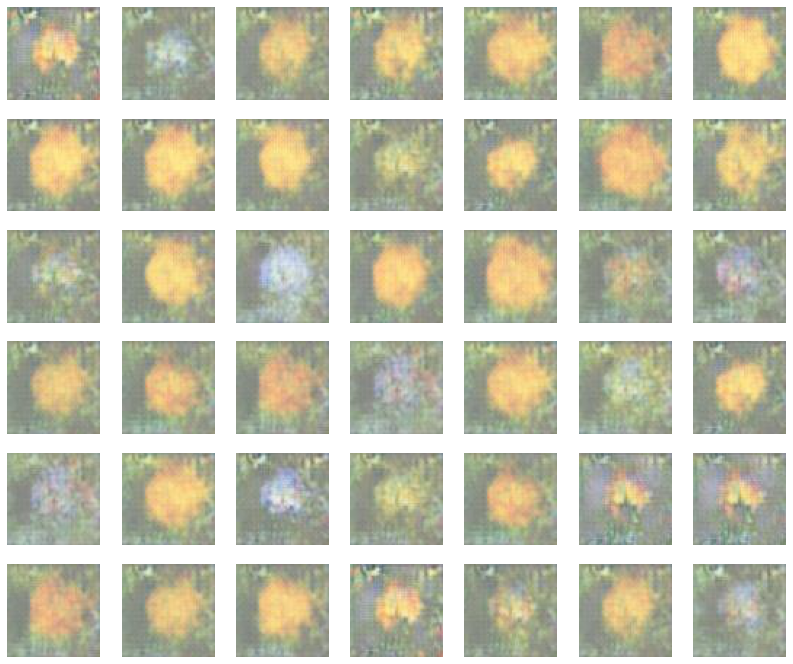

In [118]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values
index = data['ID'].values
idx = [23, 216, 224, 413, 713, 859, 876, 974, 1177, 1179, 1241, 2169, 2196, 2237, 
       2356, 2611, 2621, 2786, 2951, 2962, 3145, 3255, 3327, 3639, 3654, 3927, 4262, 
       4321, 4517, 5067, 5147, 5955, 6167, 6216, 6410, 6413, 6579, 6584, 6804, 6988, 
       7049, 7160]

visualize(idx)

some sparse thin pink petals surround a very long pistil with green stigma 
the flower has orange petals with brown stamen that float 
the flower has round light pink petals that point up 
this flower has petals that are orange with black dots 
this flower is pink in color with petals that are striped near the center 
this flower has petals that are lavender with purple filaments and green anthers 
five white petals yellow centers are arranged around six pistils 
this flower has a single layer of bright pink purple large petals with a center area that is white 
this flower is red green and yellow in color with a single large petal 
the flower is red with petals that are soft and separately arranged around stamens forming bowl shape 
this yellow flower has four tapered petals and a thin green pistil similar to the color of the stem 
this yellow flower has four tapered petals and a thin green pistil similar to the color of the stem 
this flower has pink flowers green sepal and pedicel an

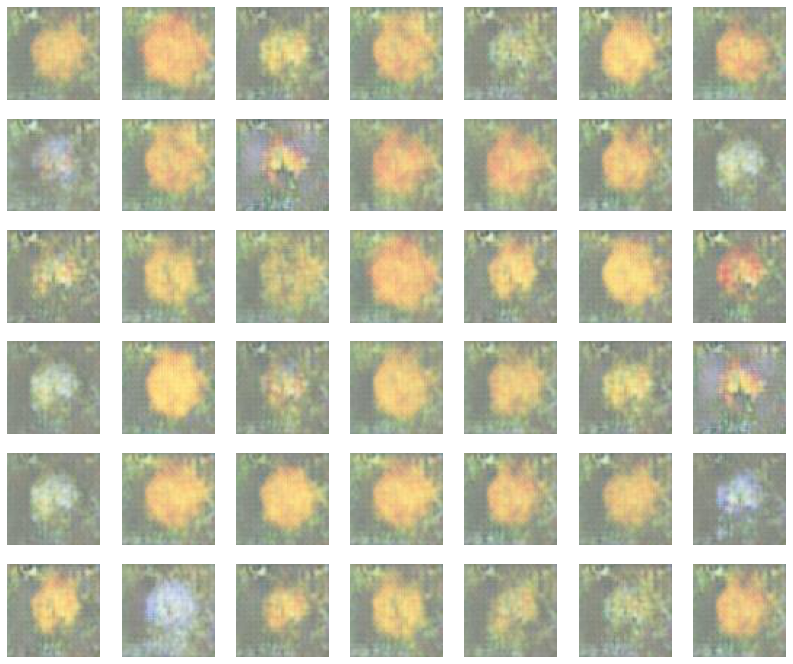

In [119]:
DATA_PATH = './inference/demo/'
img_path = Path(DATA_PATH).glob('*.jpg')
img_path = [str(path.resolve()) for path in img_path]
img_path = np.asarray(img_path)

idx = np.random.randint(len(captions), size=42)
idx.sort()

random_idx = []
for each in idx:
    path = img_path[each].split("/")
    path = path[-1].replace('inference_', '')
    random_idx.append(int(path.replace('.jpg', '')))
    
visualize(random_idx)